$$\require{mhchem}$$

# Curve fitting with two species and multiple data (20 pt)

Consider the irreversible reaction:
\begin{align*}
\ce{A + B -> Products}
\end{align*}
with $r=kC_A^nC_B^m$ taking place in an isothermal liquid-phase batch reactor. Measurements of $C_A$ vs $C_B$ are included in the attached file HW6_p1_data.dat. We wish to determine from the data the rate constant and the order of the reaction with respect to A and B.  We have data from two experiments. 

## Load the data from the file into a numpy array and plot the concentration of each species

You can use either the csv library https://docs.python.org/3/library/csv.html or pandas https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html. 

The first column is time in minutes. The second and third column is C_A and C_B for the first experiment (in mol/L). The fourth and fifth column is C_A and C_B for the second experiment. Plot the data for $C_A$ and $C_B$ for each experiment (one experiment per figure).

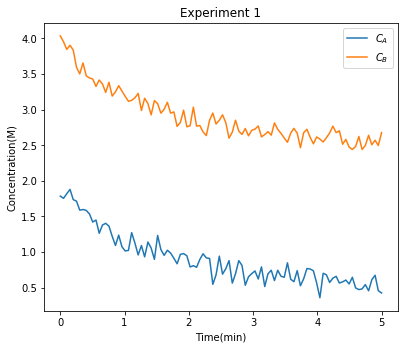

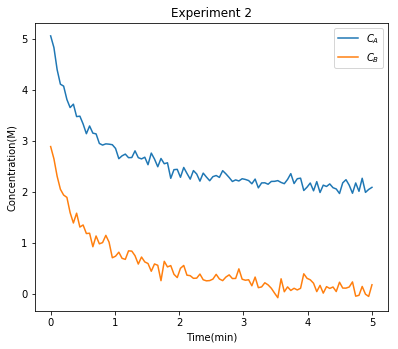

In [123]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('HW6_p1_data.dat', delim_whitespace = True)

ti = data['Time(min)']
Ca1 = data['Ca1(M)']
Cb1 = data['Cb1(M)']
Ca2 = data['Ca2(M)']
Cb2 = data['Cb2(M)']

plt.subplot(1,2,1)
plt.subplots_adjust(left=0.0, right=1.8, bottom=0.0, top=1.0)
plt.plot(ti, Ca1, label = '$C_A$')
plt.plot(ti, Cb1, label = '$C_B$')
plt.xlabel('Time(min)')
plt.ylabel('Concentration(M)')
plt.title('Experiment 1')
plt.legend()
plt.show()

plt.subplot(1,2,2)
plt.subplots_adjust(left=0.0, right=1.8, bottom=0.0, top=1.0)
plt.plot(ti, Ca2, label = '$C_A$')
plt.plot(ti, Cb2, label = '$C_B$')
plt.xlabel('Time(min)')
plt.ylabel('Concentration(M)')
plt.title('Experiment 2')
plt.legend()
plt.show()
#data

## Estimate rate parameters $k, n, m$ and initial concentration $C_{A0},C_{B0}$ from the data in the first experiment using a numerical solution for the concentrations of each species (standard mol balance + odeint). Estimate uncertainty for each of these five parameters. 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


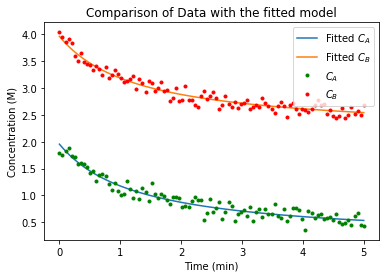

,Parameters,Value,Uncertainity
0,k,2.106462,0.089793
1,n,3.017020,0.152098
2,m,-1.779106,0.066331
3,C_A0,1.953450,0.043546
4,C_B0,3.960137,0.044530


In [124]:
import numpy as np
import pandas as pd

CA1 = np.array(Ca1)
CB1 = np.array(Cb1)
C1 = np.array([CA1,CB1])
np.set_printoptions(precision=3)

from scipy.optimize import minimize
from scipy.integrate import odeint

# The mol balance (dC/dt) as a function of time
def batch(C,t,k,n,m):
    Ca, Cb = C
    r = k * Ca**n * Cb**m
    dCadt = -r
    dCbdt = -r
    return [dCadt,dCbdt]

def solve_batch(t, k, n, m, Ca0, Cb0):
    C0 = np.array([Ca0, Cb0])
    #tspan = np.linspace(0, 5, 100)            #is it t or 5
    C = odeint(batch, C0, t, args = (k,n,m))
    return C 

def sse1(x):
    k,n,m,Ca0,Cb0 = x
    q = solve_batch(ti, k, n, m, Ca0, Cb0)
    sse = 0.5 * ((C1.T[:,0] - q[:, 0])**2 + (C1.T[:, 1] - q[:, 1])**2)
    SSE = np.sum(sse)
    return SSE

min_out = minimize(sse1, np.array([1, 1.0, 1.0, Ca1[0], Cb1[0]]))
kf, nf, mf, Ca0f, Cb0f = min_out.x

def uncertainty(min_out,num_samples):
    return np.diag(np.sqrt(min_out['hess_inv']*2*min_out.fun/(num_samples-5)))

ku, nu, mu, Ca0u, Cbu = uncertainty(min_out, 100)

Parameters = ['k', 'n', 'm', 'C_A0', 'C_B0']
df1 = pd.DataFrame({'Parameters': Parameters})
df1['Value']= min_out.x
df1['Uncertainity'] = uncertainty(min_out, 100) 
dk, dn, dm, dCa0, dCb0 = uncertainty(min_out, 100) 

# Fitted data
def model(C, t):
    Ca, Cb = C
    r = kf * Ca**nf * Cb**mf
    dCadt = -r
    dCbdt = -r  
    return [dCadt,dCbdt]

C0 = np.array([Ca0f, Cb0f])
tspan = np.linspace(0, 5, 100)  
Cfit = odeint(model, C0, tspan)

#Plot
plt.plot(tspan, Cfit[:, 0], label = 'Fitted $C_A$')
plt.plot(tspan, Cfit[:, 1], label = 'Fitted $C_B$')
plt.plot(tspan, Ca1, 'g.', label = '$C_A$')
plt.plot(tspan, Cb1, 'r.', label = '$C_B$')
plt.title('Comparison of Data with the fitted model')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.show()
df1

## Consider the second experiment, estimate the parameters using only this data. Comment on how the values and confidence intervals are different than the first case


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


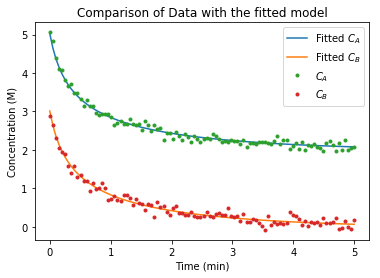

,Parameters,Values,Uncertainities
0,k,0.033663,0.025735
1,n,2.967143,0.663563
2,m,0.696364,0.202469
3,C_A0,5.022872,0.078625
4,C_B0,3.012015,0.079003


In [126]:
import numpy as np
CA2 = np.array(Ca2)
CB2 = np.array(Cb2)
C2 = np.array([CA2,CB2])
np.set_printoptions(precision=3)

from scipy.optimize import minimize
from scipy.integrate import odeint

def sse2(x):
    k,n,m,Ca0,Cb0 = x
    q = solve_batch(ti, k, n, m, Ca0, Cb0)
    sse = 0.5 * ((C2.T[:,0] - q[:, 0])**2 + (C2.T[:, 1] - q[:, 1])**2)
    SSE = np.sum(sse)
    return SSE
 
min_out = minimize(sse2, np.array([1.1, 1.0, 1.0, Ca2[0], Cb2[0]]))
kf2, nf2, mf2, Ca0f2, Cb0f2 = min_out.x


def uncertainty(min_out,num_samples):
    return np.diag(np.sqrt(min_out['hess_inv']*2*min_out.fun/(num_samples-5)))

Parameters = ['k', 'n', 'm', 'C_A0', 'C_B0']
df2 = pd.DataFrame({'Parameters': Parameters})
df2['Values'] = min_out.x
df2['Uncertainities'] = uncertainty(min_out, 100) 
dk2, dn2, dm2, dCa02, dCb02 = uncertainty(min_out, 100) 

# Fitted data
def model(C, t):
    Ca, Cb = C
    r = kf2 * Ca**nf2 * Cb**mf2
    dCadt = -r
    dCbdt = -r  
    return [dCadt,dCbdt]

C0 = np.array([Ca0f2, Cb0f2])
tspan = np.linspace(0, 5, 100)  
Cfit = odeint(model, C0, tspan)

#Plot
plt.plot(tspan, Cfit[:, 0], label = 'Fitted $C_A$')
plt.plot(tspan, Cfit[:, 1], label = 'Fitted $C_B$')
plt.plot(tspan, Ca2, '.', label = '$C_A$')
plt.plot(tspan, Cb2, '.', label = '$C_B$')
plt.title('Comparison of Data with the fitted model')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.show()
df2

In [128]:
# Comparison of values

U1 = df1['Uncertainity']
V1 = df1['Value']
U2 = df2['Uncertainities']
V2 = df2['Values']
df3 = pd.DataFrame({'Parameters': Parameters})
df3['Value for Exp 1'] = V1
df3['Value for Exp 2'] = V2
df3['Uncertainity for Exp 1'] = U1
df3['Uncertainity for Exp 2'] = U2
df3

,Parameters,Value for Exp 1,Value for Exp 2,Uncertainity for Exp 1,Uncertainity for Exp 2
0,k,2.106462,0.033663,0.089793,0.025735
1,n,3.017020,2.967143,0.152098,0.663563
2,m,-1.779106,0.696364,0.066331,0.202469
3,C_A0,1.953450,5.022872,0.043546,0.078625
4,C_B0,3.960137,3.012015,0.044530,0.079003


The values of all the parameters are different on optimization. For data set 1, we have negative order of 'B' which is doubtful since the reaction is irreversible and rate mostly increases with reactant concentration (negative order might be possible under complicated rate equations).

Though graphically it seems that data set 1 has more spread in the data points, it's uncertainity for all parameters except the rate constant is lesser. 

## Estimate the parameters using both experiments simultaneously. Are the confidence intervals better? Comment on why or why not.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


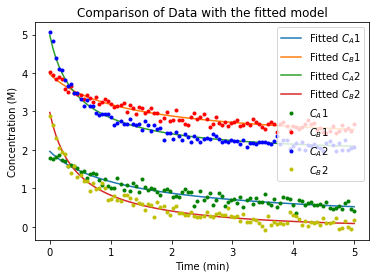

,Parameters,Value,Uncertainity
0,k,0.098082,0.006914
1,n,2.037161,0.063495
2,m,0.982113,0.050438
3,C_A10,1.962456,0.057981
4,C_B10,3.969041,0.058216
5,C_A20,4.981283,0.100592
6,C_B20,2.973442,0.101080


In [134]:
import numpy as np
import pandas as pd

CA1 = np.array(Ca1)
CB1 = np.array(Cb1)
C1 = np.array([CA1,CB1])
np.set_printoptions(precision=3)

from scipy.optimize import minimize
from scipy.integrate import odeint

# The mol balance (dC/dt) as a function of time
def batch(C,t,k,n,m):
    Ca, Cb = C
    r = k * Ca**n * Cb**m
    dCadt = -r
    dCbdt = -r
    return [dCadt,dCbdt]

def solve_batch2(t, k, n, m, Ca01, Cb01, Ca02, Cb02):
    C0_1 = np.array([Ca01, Cb01])
    C0_2 = np.array([Ca02, Cb02])
    C1 = odeint(batch, C0_1, t, args = (k,n,m))
    C2 = odeint(batch, C0_2, t, args = (k,n,m))
    return [C1, C2]

def sse1(x):
    k, n, m, Ca01, Cb01, Ca02, Cb02 = x
    q1 = solve_batch2(ti, k, n, m, Ca01, Cb01, Ca02, Cb01)[0]
    q2 = solve_batch2(ti, k, n, m, Ca01, Cb01, Ca02, Cb02)[1]
    sse = 0.5 * ((C1.T[:,0] - q1[:, 0])**2 + (C1.T[:, 1] - q1[:, 1])**2 + (C2.T[:,0] - q2[:, 0])**2 + (C2.T[:, 1] - q2[:, 1])**2)
    SSE = np.sum(sse)
    return SSE

min_out = minimize(sse1, [0.09, 1, 2, Ca1[0], Cb1[0], Ca2[0], Cb2[0]])
kf, nf, mf, Ca01f, Cb01f, Ca02f, Cb02f = min_out.x

def uncertainty(min_out,num_samples):
    return np.diag(np.sqrt(min_out['hess_inv']*2*min_out.fun/(num_samples-5)))

ku, nu, mu, Ca1u, Cb1u, Ca2u, Cb2u = uncertainty(min_out, 100)
Parameters = ['k', 'n', 'm', 'C_A10', 'C_B10', 'C_A20', 'C_B20']
df3 = pd.DataFrame({'Parameters': Parameters})
df3['Value']= min_out.x
df3['Uncertainity'] = uncertainty(min_out, 100) 

# Fitted data
def model(C, t):
    Ca1, Cb1, Ca2, Cb2 = C
    r1 = kf * Ca1**nf * Cb1**mf
    r2 = kf * Ca2**nf * Cb2**mf
    dCa1dt = -r1
    dCb1dt = -r1  
    dCa2dt = -r2
    dCb2dt = -r2  
    return [dCa1dt, dCb1dt, dCa2dt, dCb2dt]

C0 = np.array([Ca01f, Cb01f, Ca02f, Cb02f])
tspan = np.linspace(0, 5, 100)  
Cfit = odeint(model, C0, tspan)

#Plot
plt.plot(tspan, Cfit[:, 0], label = 'Fitted $C_A1$')
plt.plot(tspan, Cfit[:, 1], label = 'Fitted $C_B1$')
plt.plot(tspan, Cfit[:, 2], label = 'Fitted $C_A2$')
plt.plot(tspan, Cfit[:, 3], label = 'Fitted $C_B2$')
plt.plot(tspan, Ca1, 'g.', label = '$C_A1$')
plt.plot(tspan, Cb1, 'r.', label = '$C_B1$')
plt.plot(tspan, Ca2, 'b.', label = '$C_A2$')
plt.plot(tspan, Cb2, 'y.', label = '$C_B2$')
plt.title('Comparison of Data with the fitted model')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.show()
df3

Comparing from values in question 1.2 and 1.3, it is observed that the uncertainity values are lesser for all the parameters except the initial concentration of second data set.

**Thus, it can be confirmed that higher number of data points provide improvement in data set and reduce the uncertainity.**

## Based on these results, to determine the order of the rate expression with respect to two different species, how should you choose the initial conditions of the two species?

The initial conditions can be choosen based on observing the graph at time t = 0 or by checking the values of first few values and making the best guess for initial concentration.

## Linear least squares. Derive an expression for the linear least squared fit for this data for $\ln(-dC_A/dt)$ and $\ln(-dC_B/dt)$, analagous to how we did it in https://github.com/zulissi/f18-06625/blob/master/rxns-book/parameter-estimation.ipynb

For this batch reactor, 

<center> $r=kC_A^nC_B^m = -dC_A/dt = -dC_B/dt$
    
Now, to fit the above data, let's say we substitute the rate of consumption of A with the rate equation and taking log on both sides, we get:

<center>$\ln(-dC_A/dt) = ln(k) + n\times ln(C_A)+ m\times ln(C_B)$
    
Similarly, for B we can write:

<center>$\ln(-dC_B/dt) = ln(k) + n\times ln(C_A)+ m\times ln(C_B)$

We can now use linear least squared analysis to get the variables: k, m and n.

## Using the second set of data (without the noise) in HW6_p1_data_error_free.dat, estimate the derivative for each curve and fit $k, n, m$ for each of three cases:
- Just data from experiment 1
- Just data from experiment 2
- Data from experiment 1 and 2

You probably want to fit this by taking the average of these two estimates for the reaction rate, but you could also fit this by having the linear regression fit both curves at the same time (for example, fit the derivative of A and B as extra data). Include estimates of uncertainty in each parameter. You can use either derivate data from the polynomial-fit curve or the raw data using finite differences (as in class).

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pycse import deriv, regress

data=pd.read_csv('HW6_p1_data_error_free.dat', delim_whitespace = True)

t = data['Time(min)']
Ca1 = data['Ca1(M)']
Cb1 = data['Cb1(M)']
Ca2 = data['Ca2(M)']
Cb2 = data['Cb2(M)']

dCA1dt = deriv(t, Ca1)
dCB1dt = deriv(t, Cb1)
dCA2dt = deriv(t, Ca2)
dCB2dt = deriv(t, Cb2)

lCa1 = np.log(Ca1)
lCa2 = np.log(Ca2)
lCb1 = np.log(Cb1)
lCb2 = np.log(Cb2)

ldCa1 = np.log(-dCA1dt)
ldCa2 = np.log(-dCA2dt)
ldCb1 = np.log(-dCB1dt)
ldCb2 = np.log(-dCB2dt)

# Data from experiment 1
X1 = np.column_stack([lCa1**0, lCa1, lCb1])   # k, n, m
p1, pint1, se1 = regress(X1, ldCa1, 0.05)

# Data from experiment 2
X2 = np.column_stack([lCa1**0, lCa2, lCb2])   # k, n, m
p2, pint2, se2 = regress(X2, ldCa2, 0.05)

# Data from experiment 1 and 2
ti = np.array([t, t])
time = [x for xs in ti for x in xs]
Ca = np.array([Ca1, Ca2])
CA = [x for xs in Ca for x in xs]
Cb = np.array([Cb1, Cb2])
CB = [x for xs in Cb for x in xs]

lCa = np.log(CA)
lCb = np.log(CB)
dCAdt = deriv(time, CA)
ldCa = np.log(-dCAdt)

X3 = np.column_stack([lCa**0, lCa, lCb])   # k, n, m
p3, pint3, se3 = regress(X3, ldCa, 0.05)

print('Experiment 1, Experiment 2, Both Experiment')

for i in range(len(p1)):
    print(p1[i], p2[i], p3[i])
    
X3.shape
#ldCa

Experiment 1, Experiment 2, Both Experiment
-2.171391199287043 -2.2362598802732023 -2.2583962471068557
2.0365224679462206 1.9395831757639928 1.890266472982035
0.881778693216063 1.0110064320197905 0.9656717359236745


/opt/conda/lib/python3.6/site-packages/pycse/PYCSE.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(A, y)


(200, 3)

## Finally, using the noisy data in HW6_p1_data.dat, estimate the derivative for each curve and fit $k, n, m$ for each of three cases:
- Just data from experiment 1
- Just data from experiment 2
- Data from experiment 1 and 2

Hint: for the linear regression to work, all of the data must be real numbers. If one of your gradient estimates is positive, log(-dC/dt) will be negative, so you have to remove those points or find a way to smooth where that doesn't happen. Same thing for C; if the data says it is negative, then the log will be undefined and you have to either remove or smooth those points.

/opt/conda/lib/python3.6/site-packages/pycse/PYCSE.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(A, y)


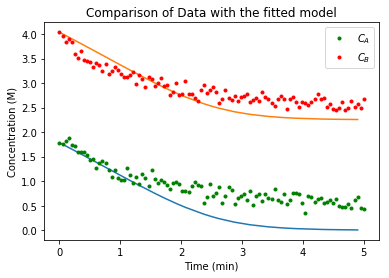

In [139]:
import matplotlib.pyplot as plt
from pycse import deriv, regress
import math

data=pd.read_csv('HW6_p1_data.dat', delim_whitespace = True)

t = data['Time(min)']
Ca1 = data['Ca1(M)']
Cb1 = data['Cb1(M)']
Ca2 = data['Ca2(M)']
Cb2 = data['Cb2(M)']

def Fit(Ca, Cb, time):
    def Conc(Ca, Cb):
        ti = []
        Cbt = []
        Cat = []
        dCa = []
        dCb = []
        for i in range(len(time)):
            if (deriv(time,Ca)[i]<0) & (deriv(time,Cb)[i]<0) & (Ca[i]>0) & (Cb[i]>0): 
                ti.append(time[i])
                Cat.append(Ca[i])
                Cbt.append(Cb[i])
                dCa.append(deriv(time,Ca)[i])
                dCb.append(deriv(time,Cb)[i]) 
        return np.array([ti, Cat, Cbt, dCa, dCb])

    tim = Conc(Ca, Cb)[0]
    Cat = Conc(Ca, Cb)[1]
    Cbt = Conc(Ca, Cb)[2]
    dCa = Conc(Ca, Cb)[3]
    dCb = Conc(Ca, Cb)[4]

    lCa = np.log(Cat)
    lCb = np.log(Cbt) 
    ldCa = np.log(-dCa)

    X = np.column_stack([lCa**0, lCa, lCb])


    p, pint, se = regress(X, ldCa, 0.05)
    return p, tim

# First Data Set
p1 = Fit(Ca1, Cb1, t)[0]
k1 = np.exp(p1[0])
n1 = p1[1]
m1 = p1[2]
tspan1 = Fit(Ca1, Cb1, t)[1]
plt.plot(tspan1, solve_batch(tspan1, k1, n1, m1, Ca1[0], Cb1[0]))
plt.plot(t, Ca1, 'g.', label = '$C_A$')
plt.plot(t, Cb1, 'r.', label = '$C_B$')
plt.title('Comparison of Data with the fitted model')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.show()

/opt/conda/lib/python3.6/site-packages/pycse/PYCSE.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(A, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


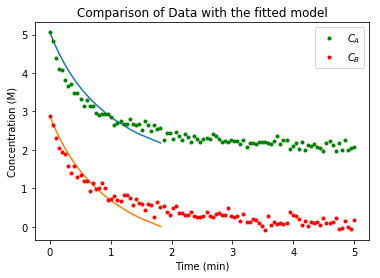

In [140]:
# Second Data Set
p2 = Fit(Ca2, Cb2, t)[0]
k2 = np.exp(p2[0])
n2 = p2[1]
m2 = p2[2]
tspan2 = Fit(Ca2, Cb2, t)[1]
plt.plot(tspan2, solve_batch(tspan2, k2, n2, m2, Ca2[0], Cb2[0]))
plt.plot(t, Ca2, 'g.', label = '$C_A$')
plt.plot(t, Cb2, 'r.', label = '$C_B$')
plt.title('Comparison of Data with the fitted model')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()

plt.show()

/opt/conda/lib/python3.6/site-packages/pycse/PYCSE.py:62: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b, res, rank, s = np.linalg.lstsq(A, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


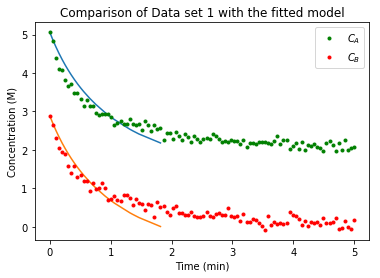

In [153]:
# Total Data
Can = np.array([Ca1, Ca2])
CA = [x for xs in Can for x in xs]
Cbn = np.array([Cb1, Cb2])
CB = [x for xs in Cbn for x in xs]
tn = np.array([t, t])
T = [x for xs in tn for x in xs]

p3 = Fit(Ca2, Cb2, t)[0]
k3 = np.exp(p2[0])
n3 = p3[1]
m3 = p3[2]
tspan3 = Fit(Ca2, Cb2, t)[1]

plt.plot(tspan3, solve_batch(tspan3, k3, n3, m3, Ca2[0], Cb2[0]))
plt.plot(t, Ca2, 'g.', label = '$C_A$')
plt.plot(t, Cb2, 'r.', label = '$C_B$')
plt.title('Comparison of Data set 1 with the fitted model')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()

plt.show()

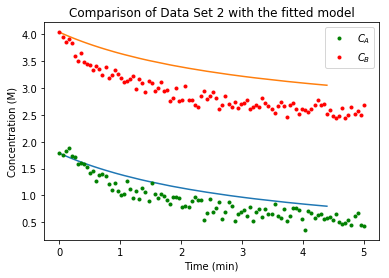

In [138]:
plt.plot(tspan3, solve_batch(tspan3, k3, n3, m3, Ca1[0], Cb1[0]))
plt.plot(t, Ca1, 'g.', label = '$C_A$')
plt.plot(t, Cb1, 'r.', label = '$C_B$')
plt.title('Comparison of Data Set 2 with the fitted model')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()
plt.show()

In [150]:
print(f'Fitting data just from experiment 1, we get k = {k1:1.3f}, n = {p1[1]:1.3f}, m = {p1[2]:1.3f}')
print(f'Fitting data just from experiment 2, we get k = {k2:1.3f}, n = {p2[1]:1.3f}, m = {p2[2]:1.3f}')
print(f'Fitting data just from experiment 3, we get k = {k3:1.3f}, n = {p3[1]:1.3f}, m = {p3[2]:1.3f}')

Fitting data just from experiment 1, we get k = 18.573, n = 1.017, m = -2.829
Fitting data just from experiment 2, we get k = 0.144, n = 2.021, m = 0.070
Fitting data just from experiment 3, we get k = 0.144, n = 2.021, m = 0.070


## Which method of estimating parameters would you recommend in this situation?

The Minimize function is the better option amongst the two because:
- It has capbaility of giving an estimate of even initial concentrations of A and B.
- Most importantly, the fit isn't as good to the data set as compared to the fit by the minimize function (it can be checked by evaluating sum square of errors).
